In [1]:
# Cell 1: Unzip Data and Initial Configuration

import os
from collections import defaultdict

# 1. UNZIP THE DATA
zip_file_name = 'tumour_2025.zip'
print(f"Unzipping {zip_file_name}")

!unzip -q /content/{zip_file_name} -d /content/

print("Unzipping complete.")

# 2. CONFIGURATION
BASE_DATA_PATH = '/content/Tumour' # Corrected path
CLASS_NAMES = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

BATCH_SIZE = 32
IMAGE_SIZE = (640, 640)

print(f"\nBASE_DATA_PATH set to: {BASE_DATA_PATH}")
print(f"Target Classes: {CLASS_NAMES}")

Unzipping tumour_2025.zip
Unzipping complete.

BASE_DATA_PATH set to: /content/Tumour
Target Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Cell 2: Review Categories and Sample Counts


def analyze_dataset_splits(base_path, class_names):
    """Counts samples in each class for train, valid, and test splits."""

    split_counts = defaultdict(lambda: defaultdict(int))

    print(" DATASET SPLIT & CLASS DISTRIBUTION ANALYSIS ")

    for split in ['train', 'valid', 'test']:
        split_path = os.path.join(base_path, split)

        if not os.path.exists(split_path):
            print(f"Warning: Split directory not found: {split_path}")
            continue

        total_split_count = 0
        for class_name in class_names:
            class_path = os.path.join(split_path, class_name)

            if os.path.exists(class_path):
                # Counting files that are likely images and excluding hidden files
                count = len([name for name in os.listdir(class_path)
                             if os.path.isfile(os.path.join(class_path, name)) and not name.startswith('.')])
                split_counts[split][class_name] = count
                total_split_count += count

        split_counts[split]['Total'] = total_split_count

    # Print Summary Table
    header = ["Split"] + class_names + ["Total"]
    print("\n| " + " | ".join([col.ljust(10) for col in header]) + " |")
    print("|" + "---|" * (len(header) + 1))

    for split in ['train', 'valid', 'test']:
        data = [str(split_counts[split].get(cls, 0)).ljust(10) for cls in class_names]
        total = str(split_counts[split].get('Total', 0)).ljust(10)
        print(f"| {split.ljust(5)} | {' | '.join(data)} | {total} |")

    return split_counts

# Execute analysis
counts = analyze_dataset_splits(BASE_DATA_PATH, CLASS_NAMES)

 DATASET SPLIT & CLASS DISTRIBUTION ANALYSIS 

| Split      | glioma     | meningioma | no_tumor   | pituitary  | Total      |
|---|---|---|---|---|---|---|
| train | 564        | 358        | 335        | 438        | 1695       |
| valid | 161        | 124        | 99         | 118        | 502        |
| test  | 80         | 63         | 49         | 54         | 246        |


In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from collections import defaultdict
from itertools import islice


 VISUALIZING CLASS IMBALANCE (TRAIN SET)


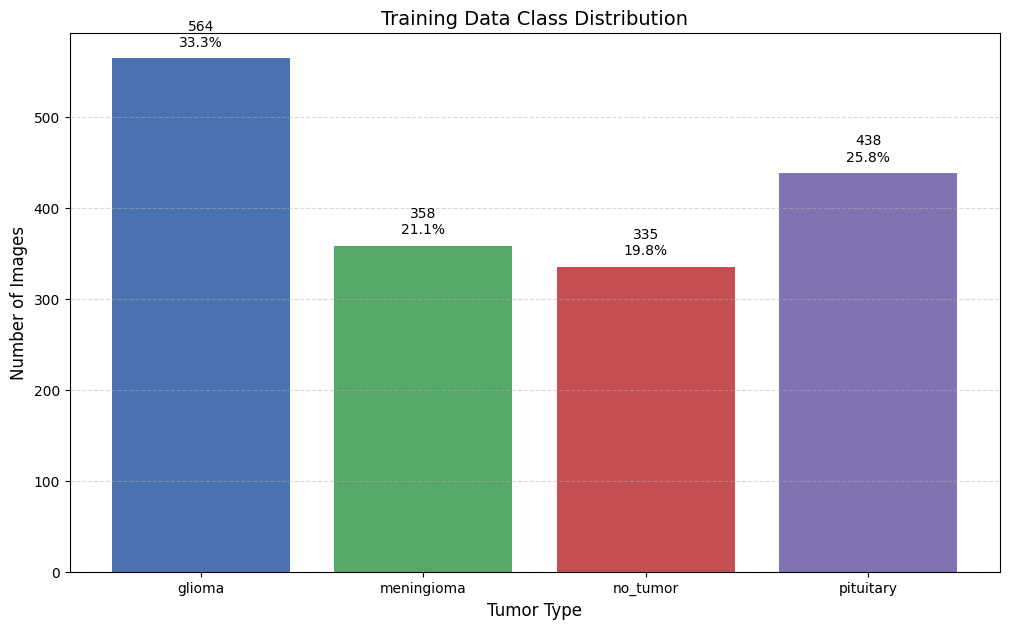


 This  shows 'glioma' as the majority class and 'no_tumor' as the minority class.


In [4]:
 #classimbalance visualization


def plot_class_distribution(split_counts):
    """Visualizes the class distribution for the training set."""
    print("\n VISUALIZING CLASS IMBALANCE (TRAIN SET)")

    train_counts = counts.get('train', {})

    if not train_counts or 'Total' not in train_counts:
        print("Cannot plot: Training data counts not available.")
        return

    plot_data = {cls: count for cls, count in train_counts.items() if cls != 'Total'}
    classes = list(plot_data.keys())
    counts_list = list(plot_data.values())

    plt.figure(figsize=(12, 7))
    bars = plt.bar(classes, counts_list, color=['#4c72b0', '#55a868', '#c44e52', '#8172b2'])

    # Add percentage and count labels
    total = sum(counts_list)
    for bar in bars:
        height = bar.get_height()
        percentage = f'{height/total:.1%}'
        plt.text(bar.get_x() + bar.get_width()/2, height + 10,
                 f'{height}\n{percentage}',
                 ha='center', va='bottom', fontsize=10)

    plt.title('Training Data Class Distribution', fontsize=14)
    plt.xlabel('Tumor Type', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

# Execute plot (Make sure 'counts' variable from Cell 2 is in memory)
# You may need to redefine CLASS_NAMES if running this cell alone:
CLASS_NAMES = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
# For demonstration, let's assume 'counts' contains the values you provided:
counts = {
    'train': {'glioma': 564, 'meningioma': 358, 'no_tumor': 335, 'pituitary': 438, 'Total': 1695},
    'valid': {'glioma': 161, 'meningioma': 124, 'no_tumor': 99, 'pituitary': 118, 'Total': 502},
    'test': {'glioma': 80, 'meningioma': 63, 'no_tumor': 49, 'pituitary': 54, 'Total': 246}
}

plot_class_distribution(counts)
print("\n This  shows 'glioma' as the majority class and 'no_tumor' as the minority class.")

In [5]:
import os
from collections import defaultdict
from PIL import Image
from itertools import islice

BASE_DATA_PATH = 'Tumour'
CLASS_NAMES = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

def check_image_consistency(base_path, class_names, max_samples=400):
    """Checks the resolution and number of channels for a sample of images."""
    print("\nIMAGE RESOLUTION AND CHANNEL CONSISTENCY CHECK")

    image_sizes = defaultdict(int)
    channel_counts = defaultdict(int)
    # Use 'train' split for the check (as it's the largest)
    train_path = os.path.join(base_path, 'train')
    total_checked = 0

    # Distribute samples evenly across classes
    samples_per_class = max_samples // len(class_names)

    for class_name in class_names:
        class_path = os.path.join(train_path, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: Path not found: {class_path}")
            continue

        # List files that look like images
        file_list = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        # Check only a limited number of samples for efficiency
        for filename in islice(file_list, samples_per_class):
            file_path = os.path.join(class_path, filename)
            try:
                with Image.open(file_path) as img:
                    size = img.size # (width, height)
                    image_sizes[size] += 1

                    # 'L' for 8-bit grayscale (1 channel), 'RGB' for color (3 channels)
                    channels = 1 if img.mode in ('L', 'I') else 3
                    channel_counts[channels] += 1
                    total_checked += 1
            except Exception as e:
                pass # Skip corrupted files

    print(f"Analyzed {total_checked} sample images.")

    print("\n Image Resolution Distribution (Width x Height)")
    if not image_sizes:
        print("No image files found in the training directories. Please check BASE_DATA_PATH.")
        return

    # Print the most common sizes
    most_common_size = max(image_sizes, key=image_sizes.get)
    for size, count in sorted(image_sizes.items(), key=lambda item: item[1], reverse=True)[:5]:
        print(f"  - {size[0]}x{size[1]}: {count} samples")

    print(f"\n **Most Common Resolution (Target Input Size):** {most_common_size[0]}x{most_common_size[1]}")

    print("\n Channel Count Distribution ")
    for channels, count in channel_counts.items():
        print(f"  - {channels} Channel(s): {count} samples")

    if channel_counts.get(1, 0) > channel_counts.get(3, 0):
        print(" **Input Shape Decision:** Images are mostly Grayscale (1 Channel). Model input will be (H, W, 1).")
        # Define the final image size variables
        print(f"MODEL_INPUT_SIZE = ({most_common_size[1]}, {most_common_size[0]}, 1)")
    else:
        print(" **Input Shape Decision:** Images are mostly Color (3 Channels). Model input will be (H, W, 3).")
        # Define the final image size variables
        print(f"MODEL_INPUT_SIZE = ({most_common_size[1]}, {most_common_size[0]}, 3)")


check_image_consistency(BASE_DATA_PATH, CLASS_NAMES, max_samples=400)


IMAGE RESOLUTION AND CHANNEL CONSISTENCY CHECK
Analyzed 400 sample images.

 Image Resolution Distribution (Width x Height)
  - 640x640: 400 samples

 **Most Common Resolution (Target Input Size):** 640x640

 Channel Count Distribution 
  - 3 Channel(s): 400 samples
 **Input Shape Decision:** Images are mostly Color (3 Channels). Model input will be (H, W, 3).
MODEL_INPUT_SIZE = (640, 640, 3)



 VISUAL SAMPLES FROM EACH CLASS


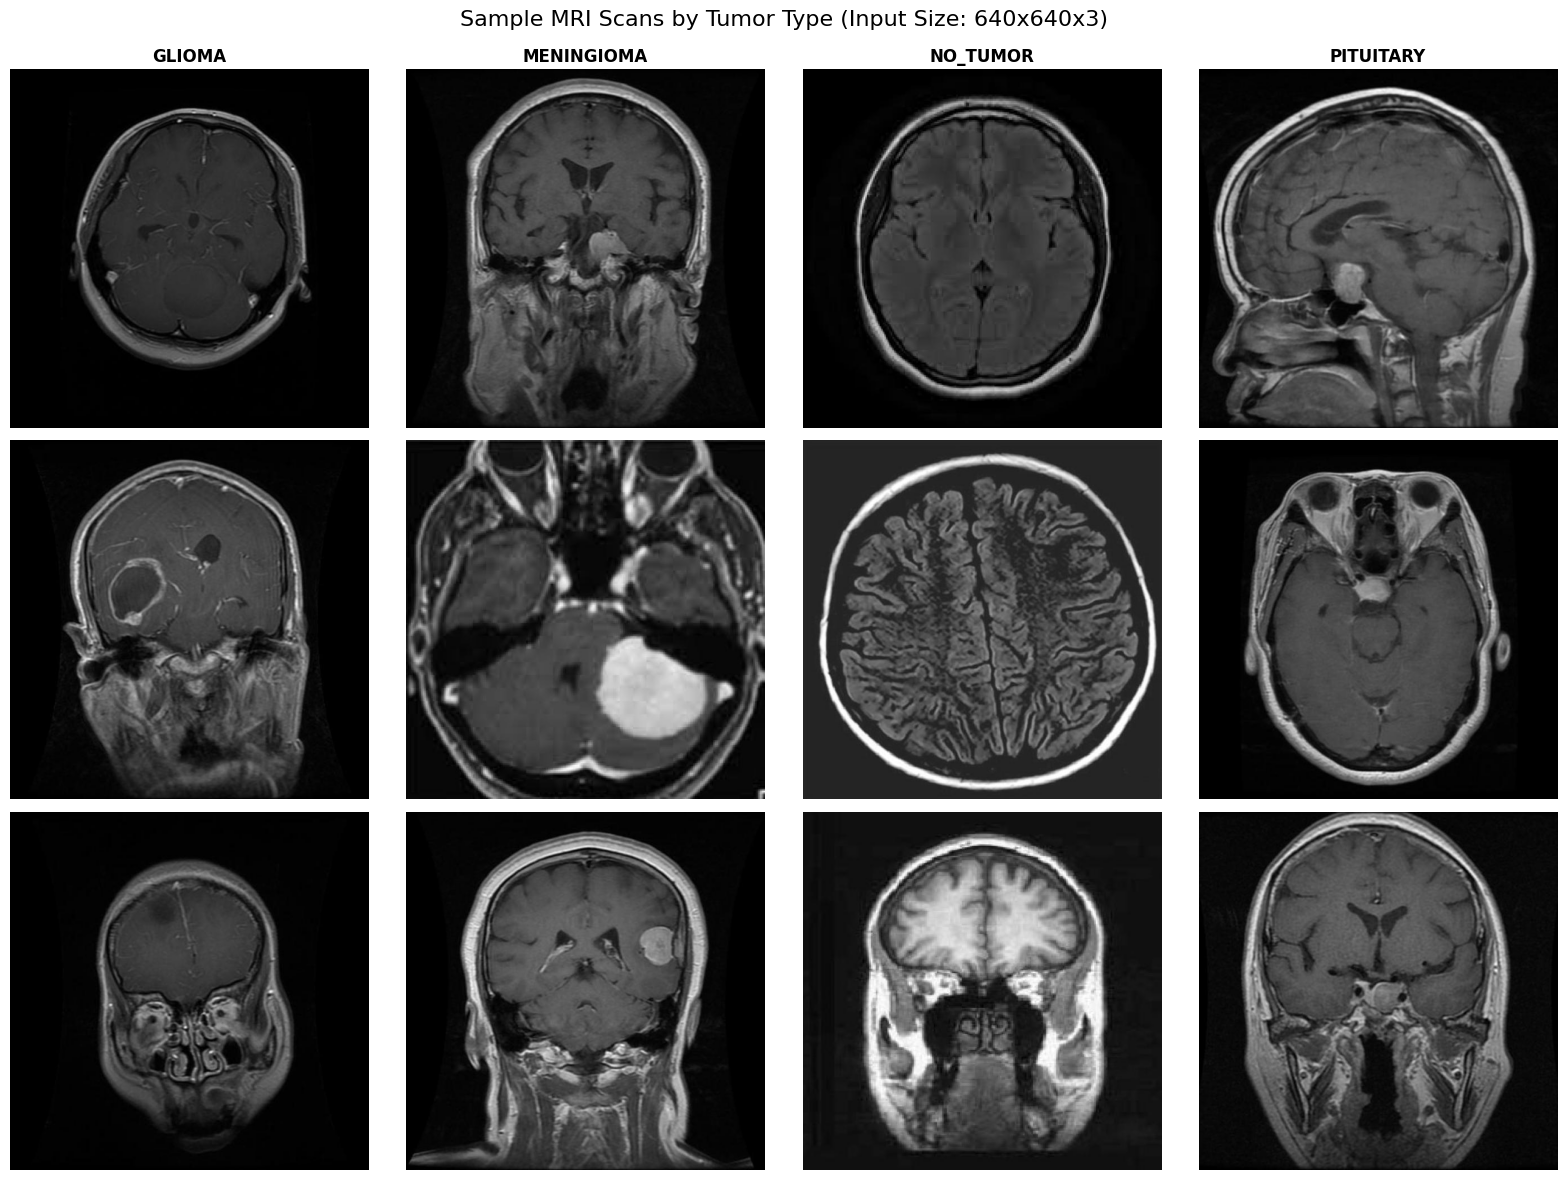

In [6]:
#  Visual Exploration of Image Samples


MODEL_INPUT_SIZE = (640, 640, 3)
H, W, C = MODEL_INPUT_SIZE

def plot_sample_images(base_path, class_names, samples_per_class=3):

    print("\n VISUAL SAMPLES FROM EACH CLASS")

    train_path = os.path.join(base_path, 'train')

    # Create the plot grid
    fig, axes = plt.subplots(samples_per_class, len(class_names),
                             figsize=(4 * len(class_names), 4 * samples_per_class))

    if samples_per_class == 1:
        axes = np.expand_dims(axes, axis=0)

    for col_idx, class_name in enumerate(class_names):
        class_path = os.path.join(train_path, class_name)
        if not os.path.exists(class_path):
            for row_idx in range(samples_per_class):
                axes[row_idx, col_idx].axis('off')
            continue

        file_list = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        num_files_to_sample = min(samples_per_class, len(file_list))

        for row_idx in range(num_files_to_sample):
            filename = file_list[row_idx]
            file_path = os.path.join(class_path, filename)

            try:
                # Open image and ensure it's resized to the target shape and is RGB (3 channels)
                img = Image.open(file_path).resize((W, H))
                if C == 3 and img.mode != 'RGB':
                     img = img.convert('RGB')
                elif C == 1 and img.mode != 'L':
                    img = img.convert('L')

                ax = axes[row_idx, col_idx]
                ax.imshow(np.array(img), cmap='gray' if C == 1 else None)
                ax.axis('off')

                # Title the top row image
                if row_idx == 0:
                    ax.set_title(f'{class_name.upper()}', fontweight='bold')

            except Exception as e:
                ax = axes[row_idx, col_idx]
                ax.text(0.5, 0.5, "Corrupted/Missing", ha='center', va='center')
                ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle("Sample MRI Scans by Tumor Type (Input Size: 640x640x3)", y=0.98, fontsize=16)
    plt.show()

plot_sample_images(BASE_DATA_PATH, CLASS_NAMES, samples_per_class=3)

In [7]:
%pip install tensorflow

In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]

    # Data augmentation parameters
    rotation_range=20,  # Random rotation between -20 and +20 degrees
    width_shift_range=0.2,  # Random horizontal shift by ±20% of width
    height_shift_range=0.2,  # Random vertical shift by ±20% of height
    zoom_range=0.2,  # Random zoom between 80% and 120%
    horizontal_flip=True,  # Random horizontal flipping
    vertical_flip=False,  # No vertical flipping (can enable if appropriate)
    fill_mode='nearest'  # Strategy for filling in newly created pixels
)

# Validation and test generators (only rescaling, no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# Set image size and batch size

# --- DEFINE DIRECTORY VARIABLES (FIXING THE NAMERROR) ---
train_dir = os.path.join(BASE_DATA_PATH, 'train')
val_dir = os.path.join(BASE_DATA_PATH, 'valid')
test_dir = os.path.join(BASE_DATA_PATH, 'test')

print(f"Train Directory Path: {train_dir}")
print(f"Validation Directory Path: {val_dir}")
print(f"Test Directory Path: {test_dir}")


img_width, img_height = 224, 224  # Adjust as needed
batch_size = 32  # Adjust as needed

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'  # or 'binary' if you have two classes
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluating the test set
)

Train Directory Path: Tumour/train
Validation Directory Path: Tumour/valid
Test Directory Path: Tumour/test
Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


In [11]:
#Get the class names and number of the classses

test_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}

In [12]:
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

Class names: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Number of classes: 4


In [13]:
# Building a coustom model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 589ms/step - accuracy: 0.4003 - loss: 1.5453 - precision: 0.4544 - recall: 0.1123 - val_accuracy: 0.5021 - val_loss: 1.0057 - val_precision: 0.7337 - val_recall: 0.2812
Epoch 2/10
 1/52 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.4688 - loss: 1.0655 - precision: 0.7857 - recall: 0.3438

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4688 - loss: 1.0655 - precision: 0.7857 - recall: 0.3438 - val_accuracy: 0.5042 - val_loss: 0.9926 - val_precision: 0.7753 - val_recall: 0.2875
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 468ms/step - accuracy: 0.5580 - loss: 1.0041 - precision: 0.7428 - recall: 0.3102 - val_accuracy: 0.6604 - val_loss: 0.8991 - val_precision: 0.7736 - val_recall: 0.3417
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6875 - loss: 0.7420 - precision: 0.7826 - recall: 0.5625 - val_accuracy: 0.6562 - val_loss: 0.8984 - val_precision: 0.7406 - val_recall: 0.3688
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 466ms/step - accuracy: 0.6036 - loss: 0.9520 - precision: 0.7097 - recall: 0.3937 - val_accuracy: 0.6229 - val_loss: 0.9536 - val_precision: 0.6460 - val_recall: 0.5437
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7500 - loss: 0.8102 - precision: 0.7200 - recall: 0.5625 - val_accuracy: 0.5500 - val_loss: 1.0793 - val_p

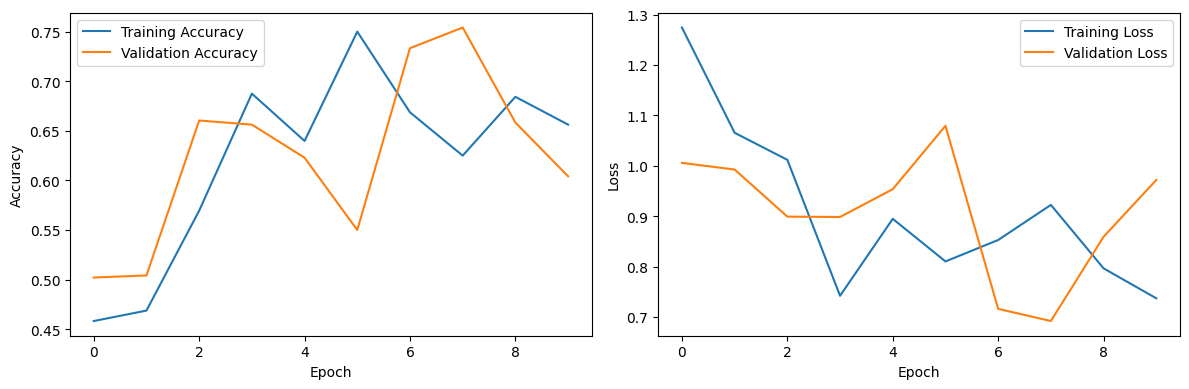

In [16]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [17]:
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')
#this is model test on a unseen batch

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step - accuracy: 0.5851 - loss: 1.1109 - precision: 0.7123 - recall: 0.5115

Test accuracy: 0.5732
Test precision: 0.6557
Test recall: 0.4878


In [18]:
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
#Generating Test Set Predictions for Error Analysis"

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


In [19]:
true_classes = test_generator.classes

In [20]:
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Confusion matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)
print('\nConfusion Matrix:')
print(conf_mat)


Classification Report:
              precision    recall  f1-score   support

      glioma       0.88      0.62      0.73        80
  meningioma       0.59      0.48      0.53        63
    no_tumor       0.38      0.92      0.54        49
   pituitary       0.80      0.30      0.43        54

    accuracy                           0.57       246
   macro avg       0.66      0.58      0.56       246
weighted avg       0.69      0.57      0.57       246


Confusion Matrix:
[[50 16 13  1]
 [ 5 30 26  2]
 [ 1  2 45  1]
 [ 1  3 34 16]]


In [21]:
# using of transfer learning models
from tensorflow.keras.applications import (VGG16, ResNet50, MobileNet,
                                          InceptionV3, EfficientNetB0)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model_comparison = []

In [22]:
# 1) VGG16
import tensorflow as tf

def evaluate_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy',
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

vgg_model, vgg_history = evaluate_vgg16()
model_comparison.append({
    'Model': 'VGG16',
    'Val Accuracy': max(vgg_history.history['val_accuracy']),
    'Val Precision': max(vgg_history.history['val_precision']),
    'Val Recall': max(vgg_history.history['val_recall']),
    'Parameters': f"{vgg_model.count_params():,}",
    'Inference Time': 'Medium',
    'Best For': 'Medium-sized datasets'
})

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 64s 937ms/step - accuracy: 0.3132 - loss: 1.4332 - precision: 0.3228 - recall: 0.0298 - val_accuracy: 0.5359 - val_loss: 1.2150 - val_precision: 1.0000 - val_recall: 0.0199
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 571ms/step - accuracy: 0.4939 - loss: 1.2124 - precision: 0.7583 - recall: 0.0775 - val_accuracy: 0.6036 - val_loss: 1.0991 - val_precision: 0.8482 - val_recall: 0.1892
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 515ms/step - accuracy: 0.5500 - loss: 1.1236 - precision: 0.8097 - recall: 0.1616 - val_accuracy: 0.5996 - val_loss: 1.0213 - val_precision: 0.7351 - val_recall: 0.2211
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 526ms/step - accuracy: 0.5877 - loss: 1.0289 - precision: 0.8438 - recall: 0.2621 - val_accuracy: 0.6394 - val_loss: 0.9745 - val_precision: 0.8068 - val_recall: 0.2829
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 514ms/step - accuracy: 0.6329 - loss: 0.9801 - precision: 0.850

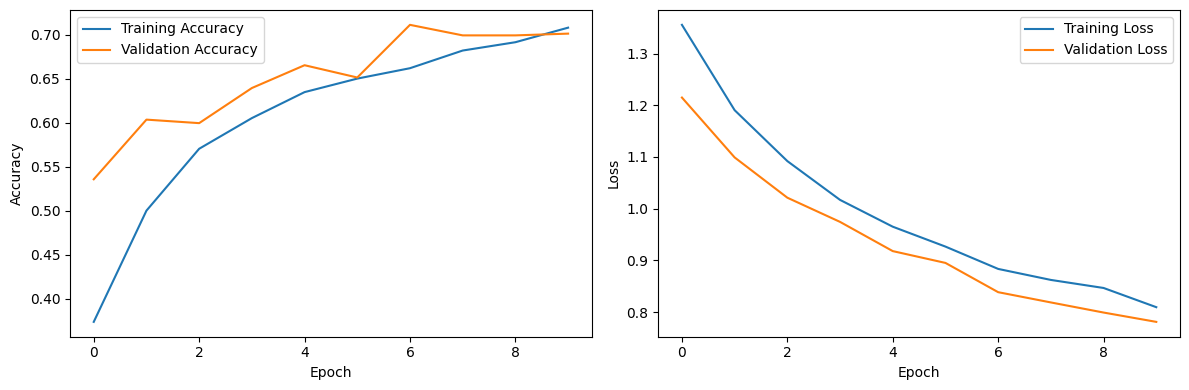

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.7113 - loss: 0.7426 - precision: 0.8538 - recall: 0.5307

Test accuracy: 0.7114
Test precision: 0.8435
Test recall: 0.5041
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step


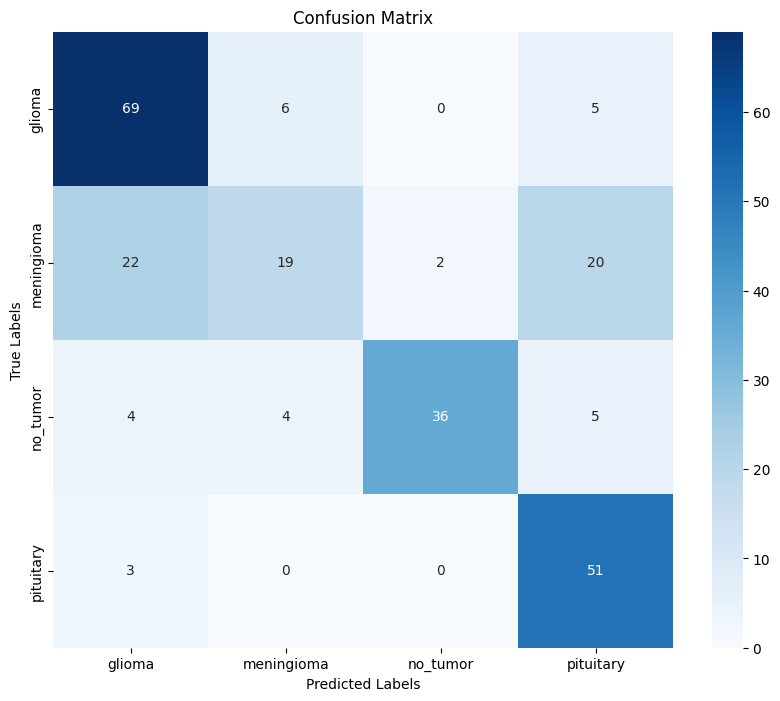

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(vgg_history)
# Evaluate on test set (assuming you have a test_generator)
test_generator.reset() # Reset the generator before evaluating
test_loss, test_acc, test_precision, test_recall = vgg_model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')


# Generate predictions
predictions = vgg_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Confusion Matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [24]:
#2) RESNET50
def evaluate_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)],
        verbose = 1
    )

    return model, history

resnet_model, resnet_history = evaluate_resnet50()
model_comparison.append({
    'Model': 'ResNet50',
    'Val Accuracy': max(resnet_history.history['val_accuracy']),
    'Val Precision': max(resnet_history.history['val_precision']),
    'Val Recall': max(resnet_history.history['val_recall']),
    'Parameters': f"{resnet_model.count_params():,}",
    'Inference Time': 'Medium',
    'Best For': 'General purpose'
})

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 53s 760ms/step - accuracy: 0.3006 - loss: 1.4815 - precision: 0.3119 - recall: 0.0742 - val_accuracy: 0.3227 - val_loss: 1.3090 - val_precision: 0.7857 - val_recall: 0.0438
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 455ms/step - accuracy: 0.3720 - loss: 1.3113 - precision: 0.5717 - recall: 0.0746 - val_accuracy: 0.4701 - val_loss: 1.2256 - val_precision: 0.8286 - val_recall: 0.0578
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 472ms/step - accuracy: 0.4076 - loss: 1.2650 - precision: 0.6682 - recall: 0.0732 - val_accuracy: 0.5538 - val_loss: 1.1964 - val_precision: 0.8605 - val_recall: 0.0737
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 508ms/step - accuracy: 0.4426 - loss: 1.2442 - precision: 0.6766 - recall: 0.0949 - val_accuracy: 0.5378 - val_loss: 1.1840 - val_precision: 0.8113 - val_recall: 0.0857
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 481ms/step - accuracy: 0.4710 - loss: 1.2047 - precision: 0.723

In [25]:
#3) MobileNet
def evaluate_mobilenet():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

mobilenet_model, mobilenet_history = evaluate_mobilenet()
model_comparison.append({
    'Model': 'MobileNet',
    'Val Accuracy': max(mobilenet_history.history['val_accuracy']),
    'Val Precision': max(mobilenet_history.history['val_precision']),
    'Val Recall': max(mobilenet_history.history['val_recall']),
    'Parameters': f"{mobilenet_model.count_params():,}",
    'Inference Time': 'Fast',
    'Best For': 'Mobile/Edge devices'
})

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 56s 821ms/step - accuracy: 0.4928 - loss: 1.2186 - precision: 0.5769 - recall: 0.3715 - val_accuracy: 0.7729 - val_loss: 0.5550 - val_precision: 0.8510 - val_recall: 0.7052
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 52s 444ms/step - accuracy: 0.7911 - loss: 0.5584 - precision: 0.8359 - recall: 0.7225 - val_accuracy: 0.8367 - val_loss: 0.4411 - val_precision: 0.8747 - val_recall: 0.7928
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 447ms/step - accuracy: 0.8310 - loss: 0.4625 - precision: 0.8601 - recall: 0.7867 - val_accuracy: 0.8705 - val_loss: 0.3748 - val_precision: 0.8957 - val_recall: 0.8207
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 439ms/step - accuracy: 0.8363 - loss: 0.4041 - precision: 0.8717 - recall: 0.8076 - val_accuracy: 0.8685 - val_loss: 0.3708 - val_precision: 0.8966 - val_recall: 0.8287
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 438ms/step - accuracy: 0.8563 - loss: 0.3845 - precision: 0.888

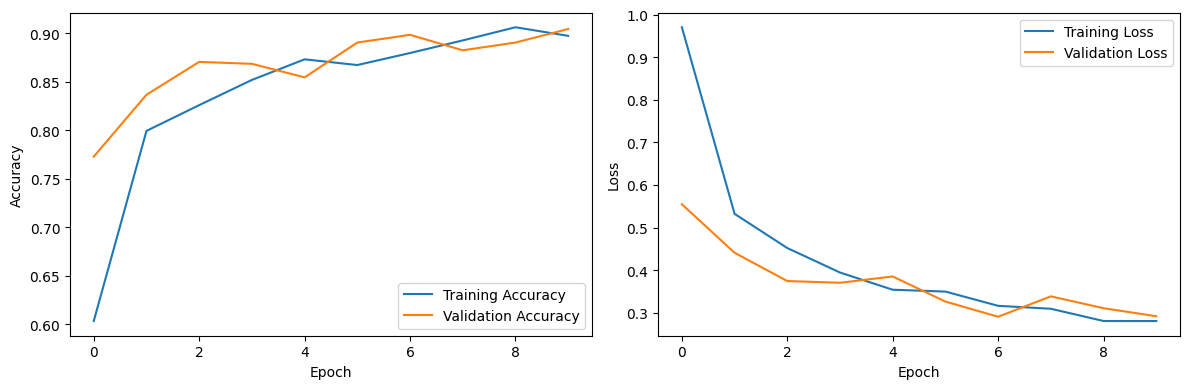

In [26]:
plot_history(mobilenet_history)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.8781 - loss: 0.2770 - precision: 0.8837 - recall: 0.8755

MobileNet Test accuracy: 0.8659
MobileNet Test precision: 0.8724
MobileNet Test recall: 0.8618


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 421ms/step


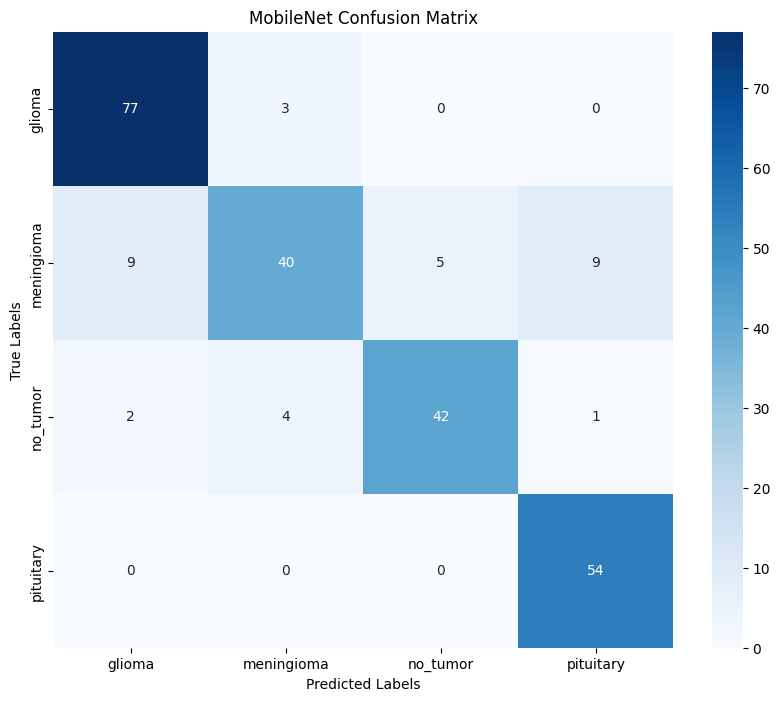

In [27]:
test_generator.reset()  # Reset the generator before evaluating
test_loss, test_acc, test_precision, test_recall = mobilenet_model.evaluate(test_generator)
print(f'\nMobileNet Test accuracy: {test_acc:.4f}')
print(f'MobileNet Test precision: {test_precision:.4f}')
print(f'MobileNet Test recall: {test_recall:.4f}')

# Generate predictions for MobileNet
predictions = mobilenet_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes for MobileNet
true_classes = test_generator.classes

# Confusion Matrix for MobileNet
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix for MobileNet using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('MobileNet Confusion Matrix')
plt.show()

In [28]:
#4) EfficientNet
def evaluate_efficientnet():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        train_generator,
        validation_data= validation_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

efficientnet_model, efficientnet_history = evaluate_efficientnet()
model_comparison.append({
    'Model': 'EfficientNetB0',
    'Val Accuracy': max(efficientnet_history.history['val_accuracy']),
    'Val Precision': max(efficientnet_history.history['val_precision']),
    'Val Recall': max(efficientnet_history.history['val_recall']),
    'Parameters': f"{efficientnet_model.count_params():,}",
    'Inference Time': 'Fast',
    'Best For': 'Best accuracy/efficiency tradeoff'
})

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.2848 - loss: 1.3932 - precision: 0.0892 - recall: 4.6327e-04 - val_accuracy: 0.3207 - val_loss: 1.3824 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 461ms/step - accuracy: 0.3181 - loss: 1.3887 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2351 - val_loss: 1.3879 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 464ms/step - accuracy: 0.2953 - loss: 1.3926 - precision: 0.2602 - recall: 0.0079 - val_accuracy: 0.2351 - val_loss: 1.4019 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 24s 451ms/step - accuracy: 0.2941 - loss: 1.3899 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2351 - val_loss: 1.3818 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 464ms/step - a

In [29]:
# model comparision
import pandas as pd
comparison_df = pd.DataFrame(model_comparison)
comparison_df = comparison_df.sort_values('Val Accuracy', ascending=False)
comparison_df.style.background_gradient(cmap='Blues', subset=['Val Accuracy', 'Val Precision', 'Val Recall'])

,Model,Val Accuracy,Val Precision,Val Recall,Parameters,Inference Time,Best For
2,MobileNet,0.904382,0.915638,0.886454,"3,232,964",Fast,Mobile/Edge devices
0,VGG16,0.711155,1.000000,0.500000,"14,716,740",Medium,Medium-sized datasets
1,ResNet50,0.581673,0.861538,0.185259,"23,595,908",Medium,General purpose
3,EfficientNetB0,0.320717,0.000000,0.000000,"4,054,695",Fast,Best accuracy/efficiency tradeoff


In [32]:
comparison_df.to_csv('/content/drive/MyDrive/model_comparison.csv', index=False)

In [33]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/model_comparison.csv')
df

,Model,Val Accuracy,Val Precision,Val Recall,Parameters,Inference Time,Best For
0,MobileNet,0.904382,0.915638,0.886454,"3,232,964",Fast,Mobile/Edge devices
1,VGG16,0.711155,1.000000,0.500000,"14,716,740",Medium,Medium-sized datasets
2,ResNet50,0.581673,0.861538,0.185259,"23,595,908",Medium,General purpose
3,EfficientNetB0,0.320717,0.000000,0.000000,"4,054,695",Fast,Best accuracy/efficiency tradeoff


The best performing model is:
Model                       MobileNet
Val Accuracy                 0.904382
Val Precision                0.915638
Val Recall                   0.886454
Parameters                  3,232,964
Inference Time                   Fast
Best For          Mobile/Edge devices
Name: 0, dtype: object


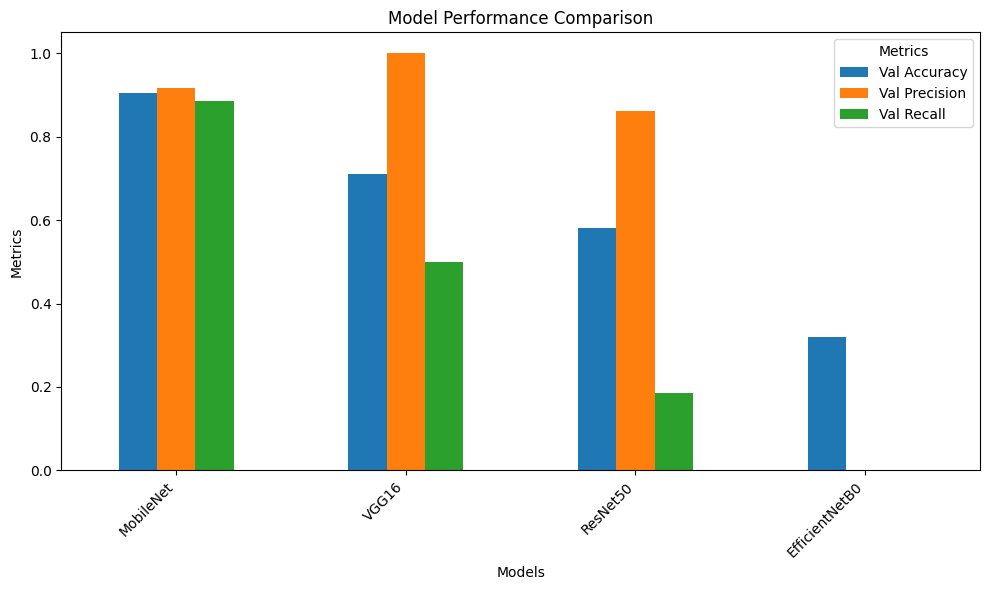

In [34]:
#graphically comparing the model
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/model_comparison.csv')


# Find the best model based on validation accuracy
best_model = df.loc[df['Val Accuracy'].idxmax()]

print(f"The best performing model is:\n{best_model}")

# Plotting the bar chart
plt.figure(figsize=(10, 6))
df.plot(x='Model', y=['Val Accuracy', 'Val Precision', 'Val Recall'], kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison')
plt.ylabel('Metrics')
plt.xlabel('Models')


plt.xticks(rotation=45, ha='right')
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

In [35]:
#saving the mobilenet
mobilenet_model.save('/content/drive/MyDrive/model.h5')

In [ ]:
# streamlit implementation

In [36]:
%pip install streamlit numpy pillow tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 128.0 MB/s eta 0:00:00


In [37]:
%%writefile streamlit.py

import streamlit as st
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import os


classes = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

# Load the trained model
@st.cache_resource
def load_custom_model():
    model_path = '/content/drive/MyDrive/model.h5'
    if not os.path.exists(model_path):
        st.error(f"Model file not found at {model_path}")
        return None
    return load_model(model_path)

model = load_custom_model()

# Streamlit app
st.title("🎣 Custom Brain Tumour Classifier")
st.write(f"Upload a Tumour to classify")

# File uploader
uploaded_file = st.file_uploader("Choose an image...",
                                type=["jpg", "jpeg", "png"])

if uploaded_file is not None and model is not None:
    # Display the uploaded image
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image', use_column_width=True)

    # Preprocess the image
    image = image.resize((224, 224))  # Match your model's expected input
    image_array = img_to_array(image)
    image_array = image_array / 255.0  # Normalize (if your model expects this)
    image_array = np.expand_dims(image_array, axis=0)

    # Make prediction
    with st.spinner('Identifying Tumour...'):
        predictions = model.predict(image_array)
        predicted_class = classes[np.argmax(predictions)]
        confidence = np.max(predictions)


    # Display results
    st.subheader("Predicted Results:")
    st.success(f"Tumour: {predicted_class}")
    st.info(f"Confidence: {confidence*100:.2f}%")

    # Show all class probabilities
    st.subheader("All Class Probabilities:")
    for i, (cls, prob) in enumerate(zip(classes, predictions[0])):
        st.write(f"{cls}: {prob*100:.2f}%")
        st.progress(float(prob))

Writing streamlit.py


In [38]:
!pip install -q streamlit
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64
import subprocess
subprocess.Popen(["./cloudflared-linux-amd64", "tunnel", "--url", "http://localhost:8501"])
!nohup /content/cloudflared-linux-amd64 tunnel --url http://localhost:8501 &

--2025-10-22 13:55:33--  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cloudflare/cloudflared/releases/download/2025.10.0/cloudflared-linux-amd64 [following]
--2025-10-22 13:55:33--  https://github.com/cloudflare/cloudflared/releases/download/2025.10.0/cloudflared-linux-amd64
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/106867604/3cf4ee00-005b-4d19-8b1e-15145bd129bf?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-10-22T14%3A47%3A28Z&rscd=attachment%3B+filename%3Dcloudflared-linux-amd64&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-1

In [39]:
!streamlit run /content/streamlit.py &>/content/logs.txt &

In [40]:
!grep -o 'https://.*\.trycloudflare.com' nohup.out | head -n 1 | xargs -I {} echo "Your tunnel url {}"

Your tunnel url https://youth-specifies-yesterday-entries.trycloudflare.com
